In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import cnn

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
data_batch_1 = unpickle("../cifar-10-batches-py/data_batch_1")

In [4]:
data_batch_1[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [5]:
batch_meta = unpickle("../cifar-10-batches-py/batches.meta")

In [6]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [7]:
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [8]:
data_batch_1[b'data'].shape

(10000, 3072)

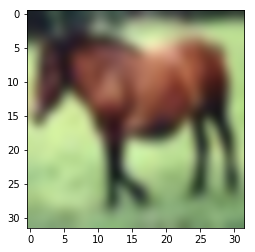

In [9]:
img=np.array(data_batch_1[b'data'][7]).reshape(3,32,32).transpose(1,2,0)
# img=img/255
plt.imshow(img,interpolation='bicubic')

In [10]:
nn=cnn.conv_net()

# Normalize

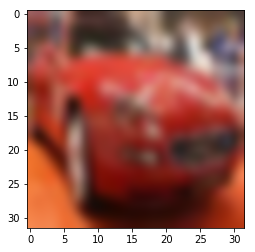

In [11]:
inp=np.array(data_batch_1[b'data'][:100]).reshape(-1,3,32,32).transpose(0,2,3,1)
inp=nn.normalize(inp)
plt.imshow(inp[5],interpolation='bicubic')

In [12]:
labels=data_batch_1[b'labels'][:100]

# One Hot encode

In [13]:
def one_hot_encode(labels):
    y_inp=np.zeros((len(labels),10))
    for ind,val in enumerate(labels):
        y_inp[ind][val]=1
    return y_inp

In [14]:
def batch_gen(st=0,size=20):
    inp=np.array(data_batch_1[b'data'][st:st+size]).reshape(-1,3,32,32).transpose(0,2,3,1)
    inp=nn.normalize(inp)
    labels=data_batch_1[b'labels'][st:st+size]
    y_inp=one_hot_encode(labels)
    return inp,y_inp

# Inititalize filters and bias

In [15]:
w0,b0=nn.init_kernel_bias(num_inp_channels=3,kernel_size=3,num_kernels=64)
w1,b1=nn.init_kernel_bias(num_inp_channels=64,kernel_size=3,num_kernels=128)
w2,b2=nn.init_kernel_bias(num_inp_channels=128,kernel_size=3,num_kernels=256)
w3,b3=nn.init_kernel_bias(num_inp_channels=256,kernel_size=3,num_kernels=512)

# Initialize fully connected layer

In [16]:
import nnet
ann=nnet.neural_net(nrons=[2048,512,256,128,10])
ann.activations(func=['relu','relu','relu','sigmoid'])

# CNN and FC with backprop

In [17]:
def train(inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,ann
    # Feed Forward
    conv0=nn.conv2d(inp,w0,b0)
    aconv0=nn.relu(conv0)
    pool0,max_index0=nn.max_pool(aconv0)

    conv1=nn.conv2d(pool0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,max_index1=nn.max_pool(aconv1)

    conv2=nn.conv2d(pool1,w2,b2)
    aconv2=nn.relu(conv2)
    pool2,max_index2=nn.max_pool(aconv2)

    conv3=nn.conv2d(pool2,w3,b3)
    aconv3=nn.relu(conv3)
    pool3,max_index3=nn.max_pool(aconv3)  #(batches, 2, 2, 512)

    r,c,d=pool3.shape[1:]
    flat=pool3.reshape(-1,r*c*d)

    err3=[]
    for flat_layer,ohe_cor in zip(flat,y_inp):
        ott=ann.feed_forward(flat_layer)
        ans=ott.argmax()
        cor=ohe_cor.argmax()
        err3.append(ann.backprop(ohe_cor)[0])

    err3=np.array(err3).reshape(-1,r,c,d)  #(batches, 2, 2, 512)
    # Back prop CNN
    d_aconv3=nn.max_pool_back(errors=err3,inp=aconv3,max_index=max_index3)
    d_conv3=nn.relu_der(aconv3,conv3)
    d_pool2,d_w3,d_b3=nn.conv2d_back(errors=d_conv3,inp=pool2,kernels=w3,biases=b3)
    w3+=d_w3
    b3+=d_b3

    d_aconv2=nn.max_pool_back(errors=d_pool2,inp=aconv2,max_index=max_index2)
    d_conv2=nn.relu_der(aconv2,conv2)
    d_pool1,d_w2,d_b2=nn.conv2d_back(errors=d_conv2,inp=pool1,kernels=w2,biases=b2)
    w2+=d_w2
    b2+=d_b2

    d_aconv1=nn.max_pool_back(errors=d_pool1,inp=aconv1,max_index=max_index1)
    d_conv1=nn.relu_der(aconv1,conv1)
    d_pool0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=pool0,kernels=w1,biases=b1)
    w1+=d_w1
    b1+=d_b1

    d_aconv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,max_index=max_index0)
    d_conv0=nn.relu_der(aconv0,conv0)
    d_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=inp,kernels=w0,biases=b0,layer=0)
    w0+=d_w0
    b0+=d_b0

In [ ]:
st=0

In [ ]:
while (st+20)<10000:
    perc=st/100
    print("\rProgress: {:.2f} %".format(perc),end='')
    inp,y_inp=batch_gen(st,size=20)
    train(inp,y_inp)
    st+=20
    if not perc%4:
        ck=np.random.randint(0,10000-100)
        inp,y_inp=batch_gen(ck,size=100)
        ncor=validate(inp,y_inp)
        print("\nValidation Acc: {:.2f} %".format(ncor))

Progress: 25.42 %

In [20]:
def validate(inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,ann
    # Feed Forward
    conv0=nn.conv2d(inp,w0,b0)
    aconv0=nn.relu(conv0)
    pool0,max_index0=nn.max_pool(aconv0)

    conv1=nn.conv2d(pool0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,max_index1=nn.max_pool(aconv1)

    conv2=nn.conv2d(pool1,w2,b2)
    aconv2=nn.relu(conv2)
    pool2,max_index2=nn.max_pool(aconv2)

    conv3=nn.conv2d(pool2,w3,b3)
    aconv3=nn.relu(conv3)
    pool3,max_index3=nn.max_pool(aconv3)  #(batches, 2, 2, 512)

    r,c,d=pool3.shape[1:]
    flat=pool3.reshape(-1,r*c*d)

    n_cor=0
    for flat_layer,ohe_cor in zip(flat,y_inp):
        ott=ann.feed_forward(flat_layer)
        ans=ott.argmax()
        cor=ohe_cor.argmax()
        if ans==cor:
            n_cor+=1
    return n_cor